### Prerequisites
This notebook requires an experimental version of the cmdty-storage package only published on Test PyPI.

`
pip install -i https://test.pypi.org/simple/ cmdty-storage==0.1.0a9
`

In [81]:
import pandas as pd
import ipywidgets as ipw
from cmdty_storage import CmdtyStorage, three_factor_seasonal_value
from datetime import date
from IPython.display import display, clear_output
%matplotlib inline

### Important Instructions
Input for the forward curve is yet to be developed. In the meantime if you want to udpate the forward price, update the fwd_curve variable in the cell below and execute this cell only before using the GUI.

In [78]:
def create_piecewise_flat_series(data, dt_index, freq):
    period_index = pd.PeriodIndex([pd.Period(dt, freq=freq) for dt in dt_index])
    return pd.Series(data, period_index).resample(freq).fillna('pad')
today = pd.Period(date.today(), freq='D')
fwd_curve = create_piecewise_flat_series([58.89, 61.41, 62.58, 58.9, 43.7], 
                         [today, today + 30, today + 60, today + 90, today + 150], freq='D')

Button(description='Calculate', style=ButtonStyle())

FloatProgress(value=0.0, max=1.0)

FloatText(value=0.0, description='Full Value', disabled=True)

Output()

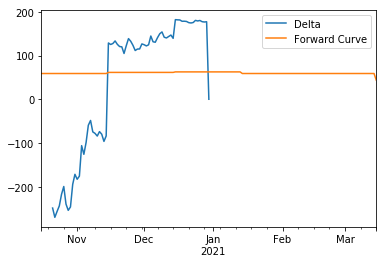

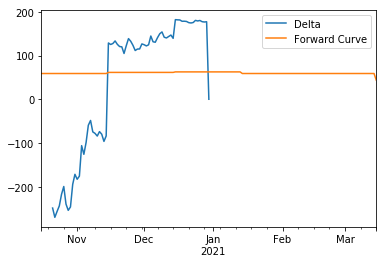

In [82]:

start_wgt = ipw.DatePicker(description='Start')
end_wgt = ipw.DatePicker(description='End')
invent_min_wgt = ipw.FloatText(description='Min Inventory')
invent_max_wgt = ipw.FloatText(description='Max Inventory')

inj_rate_wgt = ipw.FloatText(description='Injection Rate')
with_rate_wgt = ipw.FloatText(description='Withdrw Rate')
inj_cost_wgt = ipw.FloatText(description='Injection Cost')
with_cost_wgt = ipw.FloatText(description='Withdrw Cost')

storage_details_wgt = ipw.VBox([start_wgt, end_wgt, invent_min_wgt, invent_max_wgt, 
                                inj_rate_wgt, with_rate_wgt, inj_cost_wgt, with_cost_wgt])

val_date_wgt = ipw.DatePicker(description='Val Date', value=date.today())
inventory_wgt = ipw.FloatText(description='Inventory')

val_inputs_wgt = ipw.VBox([val_date_wgt, inventory_wgt])

ir_wgt = ipw.FloatText(description='Intrst Rate %', step=0.005)
mkt_data_wgt = ipw.HBox([ir_wgt])

spot_vol_wgt = ipw.FloatText(description='Spot Vol')
spot_mr_wgt = ipw.FloatText(description='Spot Mean Rev')
lt_vol_wgt = ipw.FloatText(description='Long Term Vol')
seas_vol_wgt = ipw.FloatText(description='Seasonal Vol')
vol_params_wgt = ipw.VBox([spot_vol_wgt, spot_mr_wgt, lt_vol_wgt, seas_vol_wgt])

num_sims_wgt = ipw.IntText(description='Num Sims', value=1000)
random_seed_wgt = ipw.IntText(description='Seed', value=11)
grid_points_wgt = ipw.IntText(description='Grid Points', value=100)
poly_degree_wgt = ipw.IntText(description='Poly Degree', value=3)
reg_cross_wgt = ipw.Checkbox(description='Regress Cross Product', value=False, disabled=True)

sim_params_wgt = ipw.VBox([num_sims_wgt, random_seed_wgt, grid_points_wgt, poly_degree_wgt,
                              reg_cross_wgt])

# Output Widgets
progress_wgt = ipw.FloatProgress(min=0.0, max=1.0)
full_value_wgt = ipw.FloatText(description='Full Value', disabled=True)
out = ipw.Output()

all_inputs_wgt = ipw.HBox([val_inputs_wgt, storage_details_wgt, ipw.VBox([mkt_data_wgt, vol_params_wgt])])

def on_progress(progress):
    progress_wgt.value = progress

# Inputs Not Defined in GUI
def twentieth_of_next_month(period): return period.asfreq('M').asfreq('D', 'end') + 20


def btn_clicked(b):
    progress_wgt.value = 0.0
    full_value_wgt.value = 0.0
    btn.disabled = True
    with out:
        clear_output()
    try:
        storage = CmdtyStorage('D', storage_start=start_wgt.value, storage_end=end_wgt.value, 
                               injection_cost=inj_cost_wgt.value, withdrawal_cost=with_cost_wgt.value,
                              min_inventory=invent_min_wgt.value, max_inventory=invent_max_wgt.value,
                              max_injection_rate=inj_rate_wgt.value, max_withdrawal_rate=with_rate_wgt.value)
        interest_rate_curve = pd.Series(index=pd.period_range(val_date_wgt.value, 
                                  twentieth_of_next_month(pd.Period(end_wgt.value, freq='D')), freq='D'), dtype='float64')
        interest_rate_curve[:] = ir_wgt.value
        val_results_3f = three_factor_seasonal_value(storage, val_date_wgt.value, inventory_wgt.value, fwd_curve=fwd_curve,
                                     interest_rates=interest_rate_curve, settlement_rule=twentieth_of_next_month,
                                    spot_mean_reversion=spot_mr_wgt.value, spot_vol=spot_vol_wgt.value,
                                    long_term_vol=lt_vol_wgt.value, seasonal_vol=seas_vol_wgt.value,
                                    num_sims=num_sims_wgt.value, seed=random_seed_wgt.value,
                                    regress_poly_degree=poly_degree_wgt.value, regress_cross_products=reg_cross_wgt.value,
                                    num_inventory_grid_points=grid_points_wgt.value, on_progress_update=on_progress)
        full_value_wgt.value = val_results_3f.npv
        with out:
            val_results_3f.deltas.plot(legend=True)
            ax = fwd_curve.plot(legend=True)
            ax.legend(['Delta', 'Forward Curve'])
    except Exception as e:
        with out:
            print('Exception:')
            print(e)
    finally:
        btn.disabled = False
    
    

btn = ipw.Button(description='Calculate')
btn.on_click(btn_clicked)  

display(all_inputs_wgt)
display(sim_params_wgt)
display(btn)
display(progress_wgt)
display(full_value_wgt)
display(out)

### To Do
* Secondary axis on charts.
* Stop 
* Interest rate curve, not flat rate.
* Inject/withdraw rate ratchets
* GUI input for forward curve.
* Ability to select granularity.
* Default inputs?